In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from matplotlib.font_manager import FontProperties
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsRegressor

In [2]:
format_plots()
#format_pizza_plots()
c = PlotConfig()
saver = save_factory(c.dana_save_path / "wheel", tight_layout=False)

In [3]:
## get ontogeny data to build a regression (until bioloigical age comes)

In [4]:
# arrange data
## arrange data for males behavioral age
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/ontogeny_males_raw_usage_df_beh_age.parquet').astype(float)
male_df = male_df[keep_syllables]

# for female:
m_df= male_df.groupby(['age','uuid']).mean()

## arrange data for wheel
wheel_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/wheel_raw_usage_matrix_v00_post_processing.parquet').astype(float)
wheel_df = wheel_df[keep_syllables]

In [5]:
# get knn regression to prdict age fit on the ontogeny data

In [6]:
# choose a model for decoder
clf = KNeighborsRegressor(n_neighbors=10)

# train on ontogeny data
y_train =m_df.index.get_level_values('age').to_numpy()
X_train=m_df.to_numpy()
clf.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [7]:
w_df = wheel_df.groupby(['age','experiment_type','age_group','uuid','mouse']).mean()

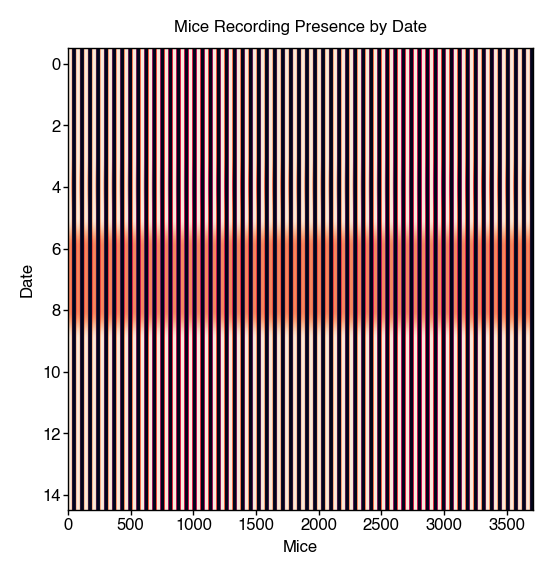

In [8]:
# Create a presence/absence matrix
# Get all unique dates and mice
df = w_df.groupby(['age','mouse']).mean()
presence_matrix = df.unstack(level='mouse').notnull().astype(int)

# Plotting the heatmap
plt.figure(figsize=(3, 3))
plt.imshow(presence_matrix.query('age<70'), aspect='auto')
plt.title('Mice Recording Presence by Date')
plt.xlabel('Mice')
plt.ylabel('Date')
plt.show()

In [9]:
# Ensure 'age' and 'mice' are indices
df = w_df.groupby(['age','mouse']).mean()
df = df.reset_index().set_index(['age', 'mouse'])

# Get all unique dates and mice
all_dates = df.index.get_level_values('age').unique()
all_mice = df.index.get_level_values('mouse').unique()

# Create a MultiIndex with all possible combinations of dates and mice
full_index = pd.MultiIndex.from_product([all_dates, all_mice], names=['age', 'mouse'])

# Reindex the DataFrame to ensure all combinations are present
df = df.reindex(full_index)

# Create a presence/absence matrix
presence_matrix = df.notnull().any(axis=1).unstack(level='mouse').astype(int)

<Axes: xlabel='mouse', ylabel='age'>

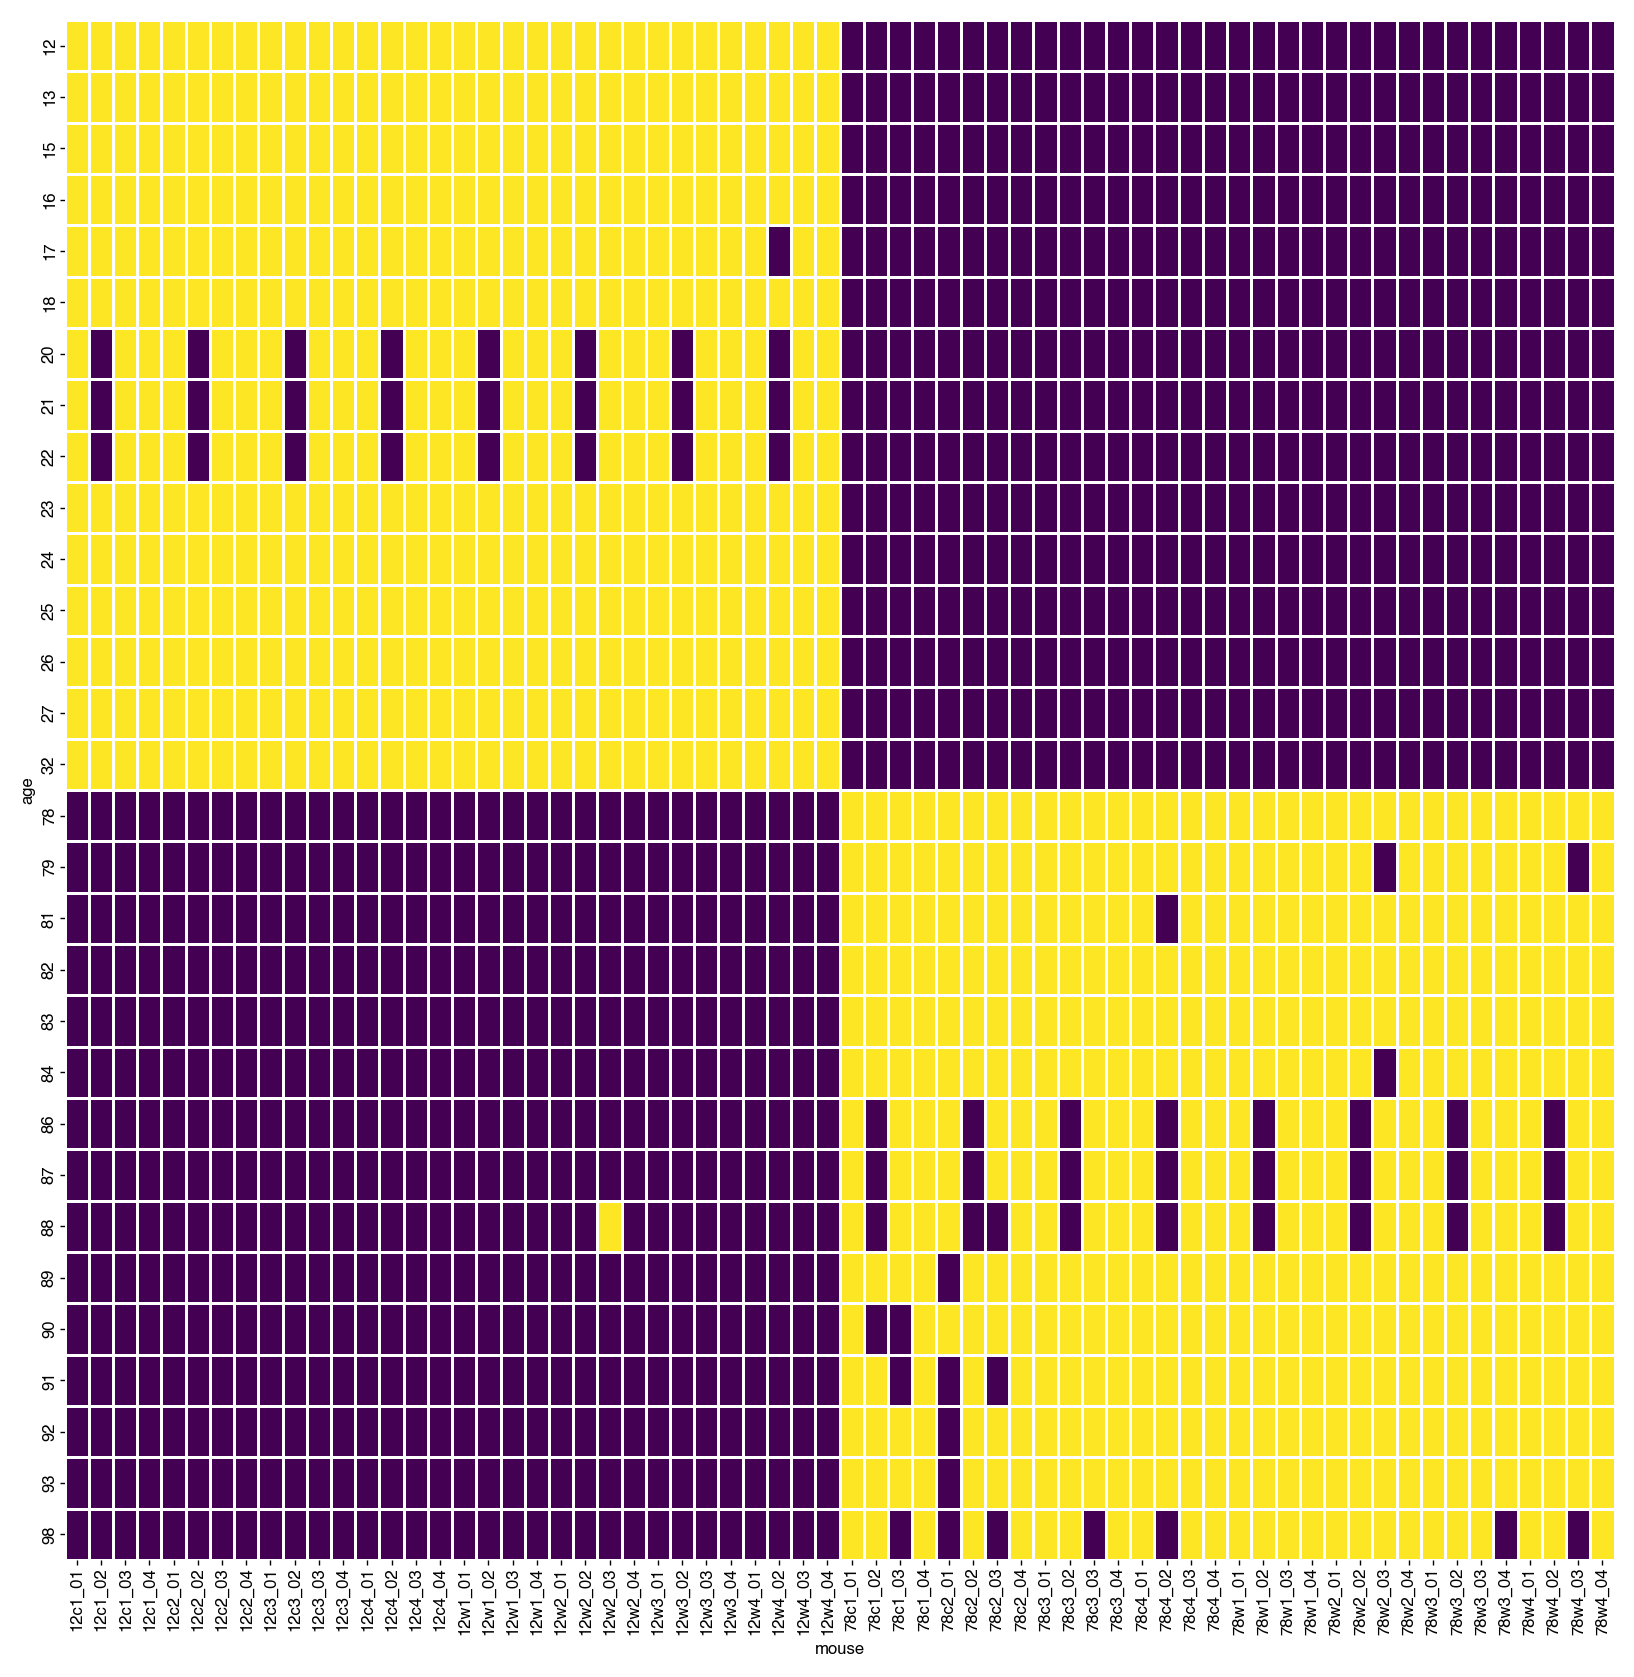

In [10]:
# Adjust figure size for better resolution
plt.figure(figsize=(10, 10))

# Plotting the heatmap with adjusted aspect ratio
sns.heatmap(presence_matrix, cmap="viridis", cbar=False, linewidths=.5)

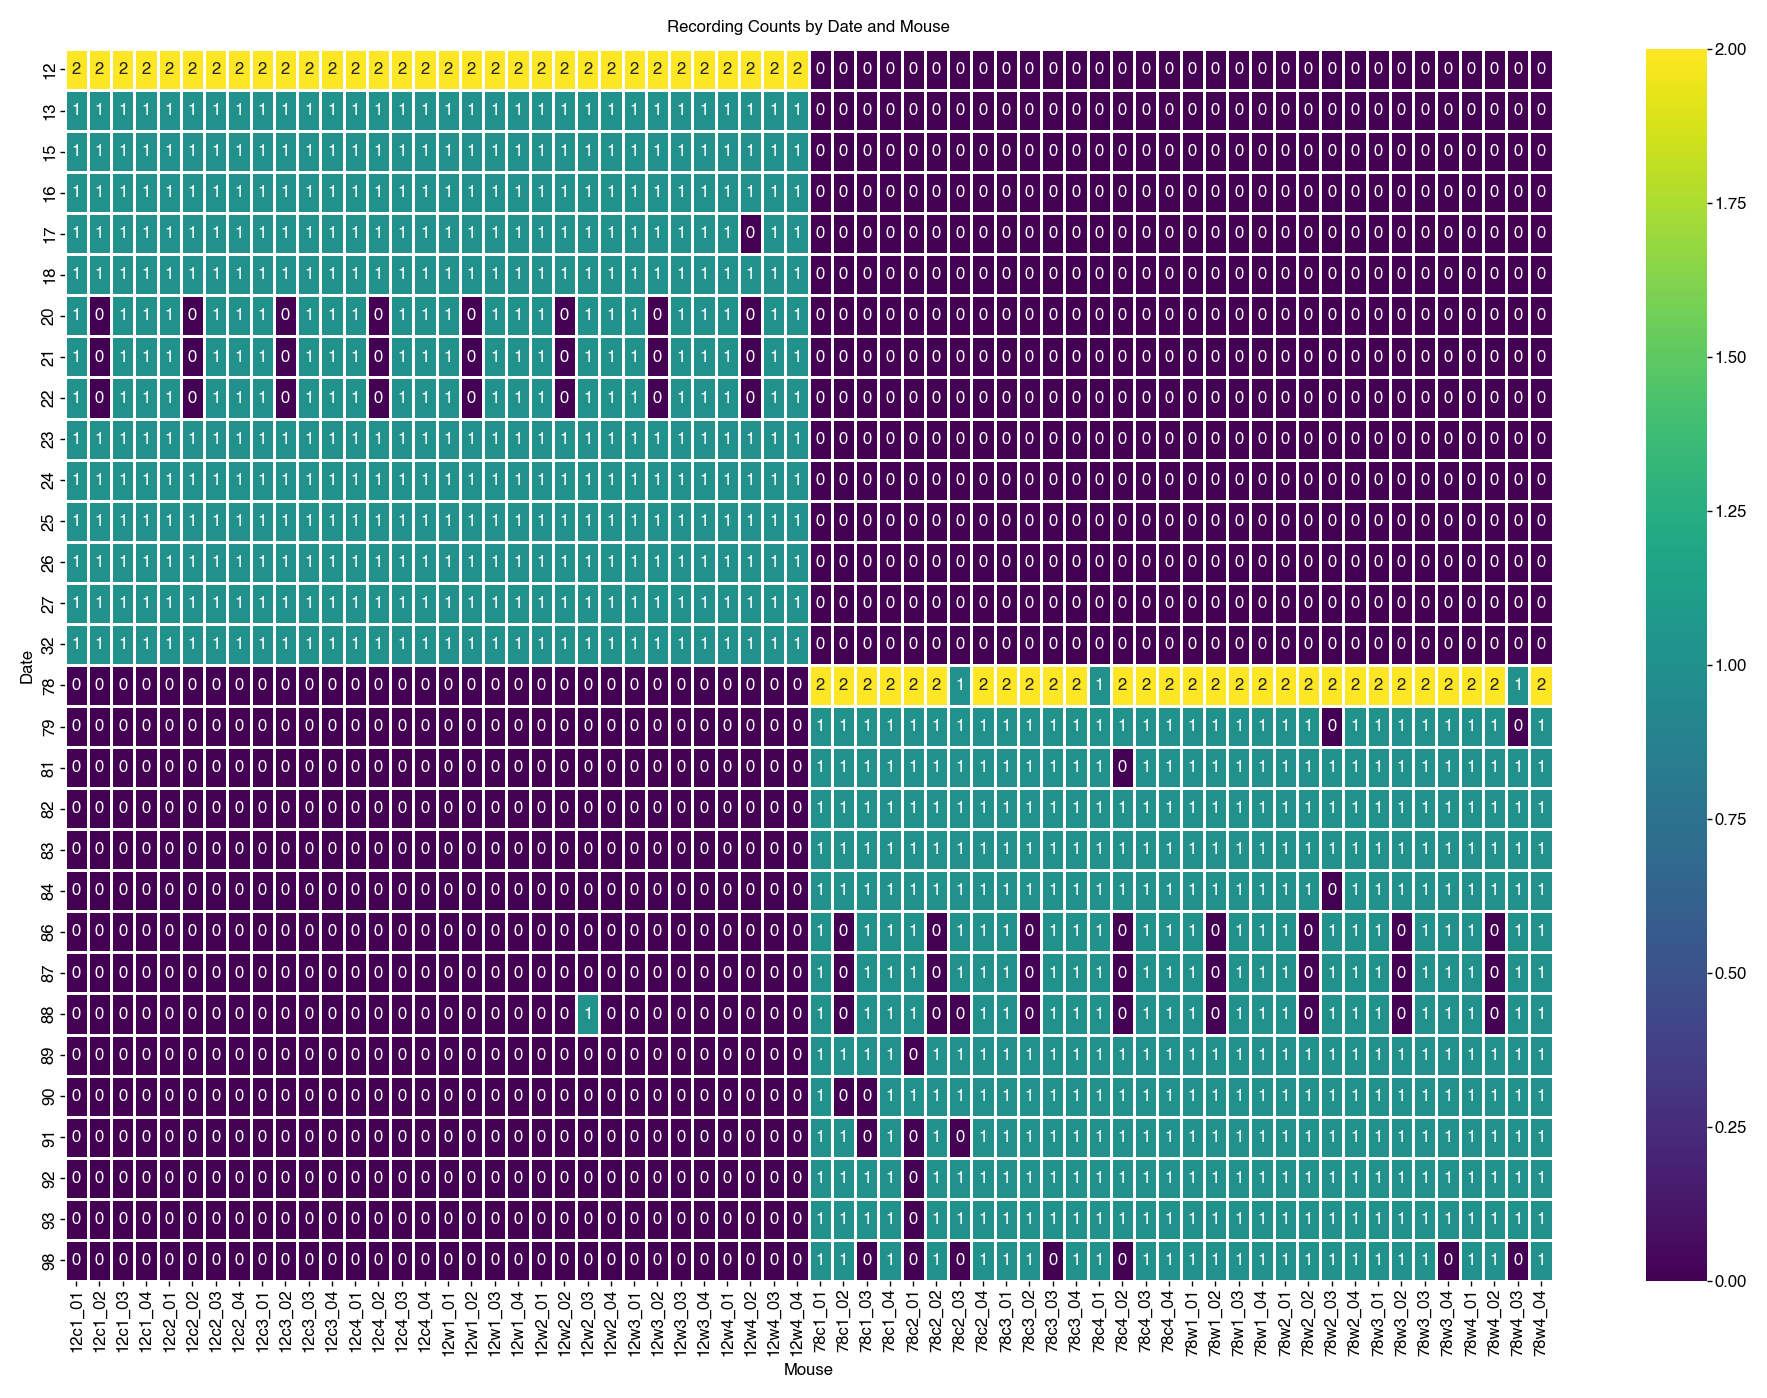

In [11]:
# Count how many times each mouse was recorded on each date
# Ensure 'age' and 'mice' are indices
df = w_df.copy()
count_matrix = df.groupby(['age', 'mouse']).size().unstack(fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(count_matrix, cmap="viridis", annot=True, linewidths=.5)
plt.title('Recording Counts by Date and Mouse')
plt.xlabel('Mouse')
plt.ylabel('Date')
plt.show()

In [12]:
# Values to drop
drop_values = [13, 79,90]
# Dropping rows with specific 'age' level values
w_df = w_df.drop(index=drop_values, level='age')

In [13]:
## behavioral age

In [14]:
# apply to wheel data
w_df['beh_age']=clf.predict(w_df)
# define an exp column
w_df['exp'] = w_df.index.get_level_values('experiment_type') + '_' + w_df.index.get_level_values('age_group')
w_df['cage'] = w_df.index.get_level_values('mouse').str[:4]
w_df.set_index(['beh_age', 'exp','cage'], append=True, inplace=True)

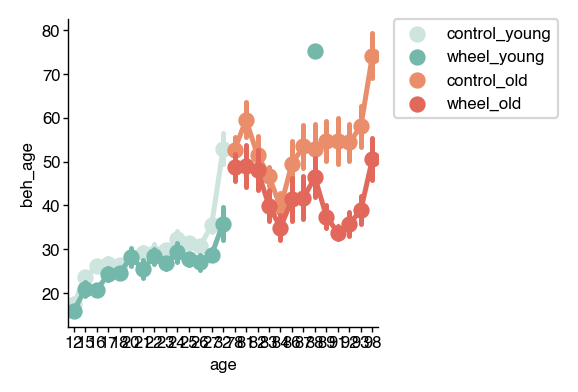

In [15]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.pointplot(
    data=w_df.reset_index(),
    x="age",
    y="beh_age",
    palette = ['#cde4df','#73b8aa','#e98d6b', '#e3685c'],
    estimator='mean',
    errorbar='se',
    hue="exp")
sns.despine()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

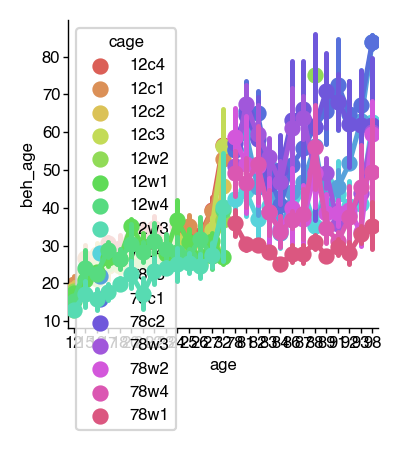

In [17]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.pointplot(
    data=w_df.reset_index(),
    x="age",
    y="beh_age",
    palette = "hls",
    estimator='mean',
    errorbar='se',
    hue="cage")
sns.despine()

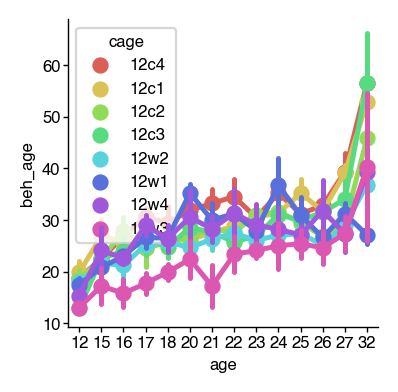

In [18]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.pointplot(
    data=w_df.query("age<70").reset_index(),
    x="age",
    y="beh_age",
    palette = "hls",
    estimator='mean',
    errorbar='se',
    hue="cage")
sns.despine()

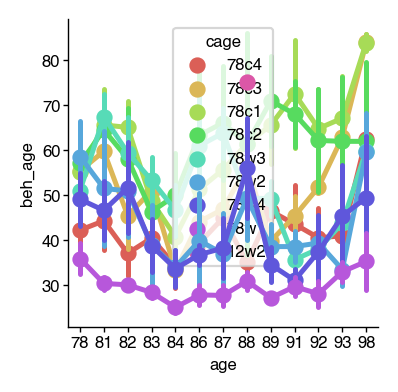

In [19]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.pointplot(
    data=w_df.query("age>70").reset_index(),
    x="age",
    y="beh_age",
    palette = "hls",
    estimator='mean',
    errorbar='se',
    hue="cage")
sns.despine()

In [20]:
## differences between the first and last datapoint

In [21]:
# calcualte absolute diff in psd between begining and end of exp
psd_diff = w_df.reset_index().groupby(['mouse','cage','exp']).apply(lambda group: group.loc[group['age'].idxmax()]["beh_age"] - group.loc[group['age'].idxmin()]["beh_age"])
psd_diff = psd_diff.reset_index()
psd_diff.columns = ['mouse','cage','exp','diff']

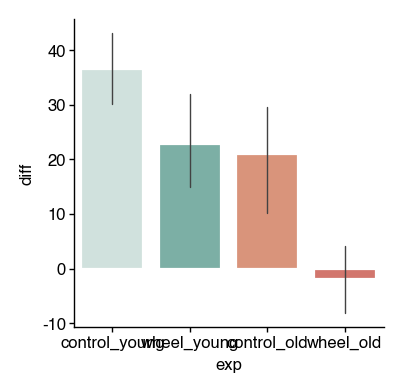

In [22]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.barplot(
    data=psd_diff, 
    x="exp", 
    palette = ['#cde4df','#73b8aa','#e98d6b', '#e3685c'],
    y="diff",
    errwidth=0.5,)
sns.despine()

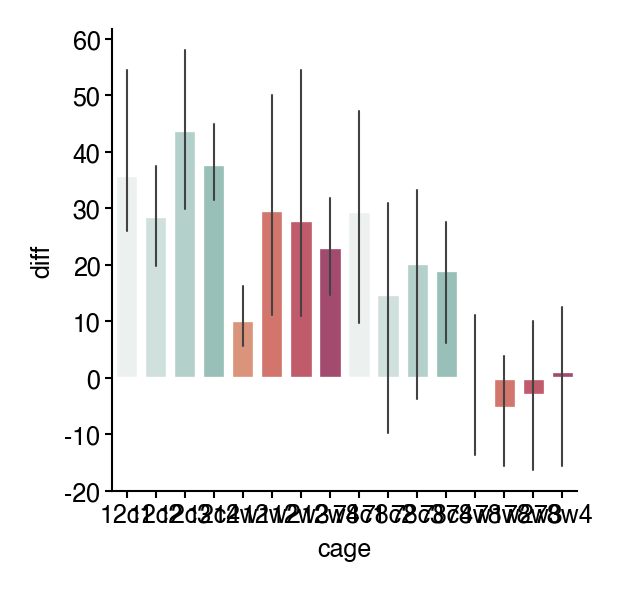

In [24]:
figure(2,2)
sns.barplot(
    data=psd_diff, 
    x="cage", 
    palette = ['#ebf2f0', '#cde4df','#afd5cd', '#91c7bc','#e98d6b', '#e3685c','#d14a61', '#b13c6c','#ebf2f0', '#cde4df','#afd5cd', '#91c7bc','#e98d6b', '#e3685c','#d14a61', '#b13c6c'],
    y="diff",
    errwidth=0.5,
)
sns.despine()